### Étape 1 : Configuration du Notebook Jupyter 

Tout d'abord, créons un nouveau notebook Jupyter et installons les dépendances nécessaires : 

In [19]:
!pip install pygad opencv-python-headless matplotlib

### Étape 2 : Imports et Fonctions Utilitaires

Nous allons commencer par importer les bibliothèques nécessaires et définir les fonctions utilitaires.

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pygad import pygad

# Fonction pour sauvegarder une image
def save_image(image, filename):
    cv2.imwrite(filename, image)
    print(f"Image enregistrée : {filename}")

# Fonction pour convertir une image Bitmap en Matrice OpenCV
def bitmap_to_mat(bitmap):
    return cv2.cvtColor(np.array(bitmap), cv2.COLOR_BGR2RGB)

# Fonction pour afficher une image
def display_image(image, title="Image"):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

### Étape 3 : Définition du Chromosome

Nous allons définir la classe `EdgeChromosome` en Python.

In [21]:
class EdgeChromosome:
    def __init__(self, length):
        self.kernel_size = 7  # Définir kernel_size avant de l'utiliser dans generate_gene
        self.length = length
        self.genes = [self.generate_gene() for _ in range(length)]

    def generate_gene(self):
        return np.random.randint(-20, 20, (self.kernel_size, self.kernel_size), dtype=np.int64)

    def get_complete_matrix(self):
        complete_matrix = np.zeros((self.kernel_size, self.kernel_size), dtype=np.int64)
        for gene in self.genes:
            complete_matrix += gene
        
        max_abs_value = np.max(np.abs(complete_matrix))
        if max_abs_value > 10:
            complete_matrix = (10.0 * complete_matrix / max_abs_value).astype(np.int64)
        
        return complete_matrix

### Étape 4 : Test du Chromosome

Testons la création d'un chromosome, ses gènes, et la matrice résultante correspondante.

In [22]:
test_chromosome = EdgeChromosome(5)
print("Gènes générés :")
for gene in test_chromosome.genes:
    print(gene)
    print()

test_matrix = test_chromosome.get_complete_matrix()
print("Matrice complète générée :")
print(test_matrix)

Gènes générés :
[[ 10   0 -19   4 -16 -14  -5]
 [-12  -4  -6  11  12  13 -15]
 [  9 -18  12  -8 -10 -15 -10]
 [  8 -20   2   8  19  11   9]
 [  2 -11   6   7   8   2 -18]
 [-20 -12  -3   5   5  -3 -13]
 [-15 -16  -6   6  10  14  -1]]

[[-16   1  -8   7  -5 -17   6]
 [ 11 -16 -13  13   9  13   5]
 [  5   8  16   1  18  11  -1]
 [ 18  14   3  15  15  10  11]
 [-10   8  10  -2   7  -5   2]
 [ 18 -18  18 -13  14  -8   0]
 [-19 -14 -13   9   8  -5  14]]

[[ 12  16   5   3  -7  16 -16]
 [-15   5  14  -7  18 -18   9]
 [-15  14   1  12  -9 -15   4]
 [-14   2  19   3   5 -19  -2]
 [-13   5   5  18 -13   0   1]
 [ 14  -7  15   2   1  10   3]
 [-12 -17   1   2 -16  16   5]]

[[ -6  12  12   1  18  13  -7]
 [  1  -3 -15 -15  13 -10   1]
 [ -7   7 -18   5   9 -15  11]
 [ 15 -14  19  14   8  -1 -17]
 [ 11  11 -19 -18  -8   4  -3]
 [ -1  16   3   9  -9  -1 -17]
 [ -6   4  -2 -12 -12  19  13]]

[[  8 -10   8  -5   6   3  -3]
 [-19   5 -18  15 -20  -5 -19]
 [-19   5  -7   4 -19  11  -8]
 [ 17   6  -5 -

### Étape 5 : Définition de la Fonction d'Évaluation

Nous allons implémenter la fonction d'évaluation en Python.

In [23]:
class EdgeFitness:
    def __init__(self, original_image):
        self.original_image = cv2.cvtColor(np.array(original_image), cv2.COLOR_BGR2RGB)
        if len(self.original_image.shape) == 3:
            self.original_image = cv2.cvtColor(self.original_image, cv2.COLOR_BGR2GRAY)
        
        # Appliquer le filtre Sobel pour référence
        self.reference_image = cv2.Sobel(self.original_image, cv2.CV_64F, 1, 0)

        if len(self.reference_image.shape) == 3:
            self.reference_image = cv2.cvtColor(self.reference_image, cv2.COLOR_BGR2GRAY)
        
        # Normaliser et convertir l'image de référence en CV_8U
        self.reference_image = cv2.normalize(self.reference_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    def display_images(self):
        save_image(self.original_image, "original.png")
        save_image(self.reference_image, "reference.png")
        display_image(self.original_image, "Original Image")
        display_image(self.reference_image, "Reference Image")

    def apply_filter(self, chromosome, display=False):
        filter_matrix = chromosome.get_complete_matrix()
        kernel = np.float32(filter_matrix)
        
        if display:
            print("Noyau généré :")
            print(kernel)
        
        source_image = self.original_image.copy()
        if source_image.dtype != np.float32:
            source_image = source_image.astype(np.float32)
        
        filtered_image = cv2.filter2D(source_image, -1, kernel)
        
        if filtered_image.dtype != self.reference_image.dtype:
            filtered_image = filtered_image.astype(self.reference_image.dtype)
        
        return filtered_image

    def evaluate(self, solution, solution_idx):
        chromosome = EdgeChromosome(20)
        chromosome.genes = [np.array(solution[i:i+49]).reshape(7, 7).astype(np.int64) for i in range(0, len(solution), 49)]
        
        filtered_image = self.apply_filter(chromosome, False)
        
        if len(filtered_image.shape) == 3:
            filtered_image = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)
        
        if len(self.reference_image.shape) == 3:
            self.reference_image = cv2.cvtColor(self.reference_image, cv2.COLOR_BGR2GRAY)
        
        if filtered_image.dtype != np.uint8:
            filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        if self.reference_image.dtype != np.uint8:
            self.reference_image = cv2.normalize(self.reference_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        if filtered_image.shape != self.reference_image.shape:
            filtered_image = cv2.resize(filtered_image, (self.reference_image.shape[1], self.reference_image.shape[0]))
        
        result = cv2.matchTemplate(filtered_image, self.reference_image, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        
        filter_matrix = chromosome.get_complete_matrix()
        filter_sum = np.sum(filter_matrix)
        filter_penalty = 1 if abs(filter_sum) < 1e-3 else np.log10(abs(filter_sum) + 1)
        
        return max_val / filter_penalty

    def display_chromosome_result(self, chromosome, filename_prefix, generation):
        filtered_image = self.apply_filter(chromosome, True)
        filename = f"{filename_prefix}_generation_{generation}.png"
        save_image(filtered_image, filename)
        display_image(filtered_image, f"Generation {generation}")

### Étape 6 : Test de la Fonction Fitness

Test de la fonction fitness.

In [24]:
from PIL import Image
# Test de la fonction fitness
image_path = r"E:\Dev\AI\Cours\CoursIA\MyIA.AI.Notebooks\Search\MRI_Prostate_Cancer.jpg"
original_image = Image.open(image_path)
fitness = EdgeFitness(original_image)

# Test d'un chromosome
chromosome = EdgeChromosome(20)
print(f"Score de fitness : {fitness.evaluate(np.concatenate([gene.flatten() for gene in chromosome.genes]), 0)}")

Score de fitness : 0.0021530460381361393


### Étape 7 : Configuration de l'Algorithme Génétique

Configuration de l'algorithme génétique avec une population, une fonction de sélection, un opérateur de croisement et un opérateur de mutation.


Image enregistrée : original.png
Image enregistrée : reference.png


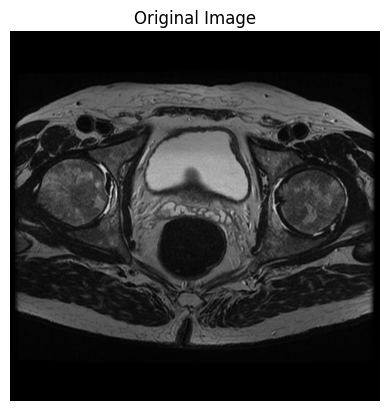

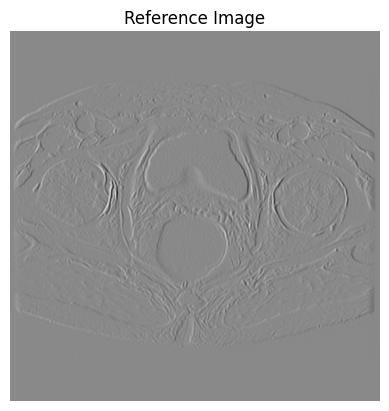

In [25]:
# Charger une image de test
image_path = r"E:\Dev\AI\Cours\CoursIA\MyIA.AI.Notebooks\Search\MRI_Prostate_Cancer.jpg"  # Remplacez par le chemin de votre image

original_image = Image.open(image_path)
fitness = EdgeFitness(original_image)
fitness.display_images()

# Initialiser un chromosome
chromosome_length = 20 * 49  # 20 gènes, chaque gène est une matrice 7x7

# Initialiser la population
population_size = (50, chromosome_length)

# Fonction de fitness
def fitness_func(ga_instance, solution, solution_idx):
    chromosome = EdgeChromosome(20)
    chromosome.genes = [np.array(solution[i:i+49]).reshape(7, 7).astype(np.int64) for i in range(0, len(solution), 49)]
    return fitness.evaluate(solution, solution_idx)

def on_generation(ga_instance):
    best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution()
    best_chromosome = EdgeChromosome(20)
    best_chromosome.genes = [np.array(best_solution[i:i+49]).reshape(7, 7).astype(np.int64) for i in range(0, len(best_solution), 49)]
    print(f"Génération {ga_instance.generations_completed} - Meilleur score : {best_solution_fitness}")
    
    if ga_instance.generations_completed % 10 == 0:
        fitness.display_chromosome_result(best_chromosome, "best", ga_instance.generations_completed)

# Configurer les opérateurs génétiques
ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=10,
    fitness_func=fitness_func,
    sol_per_pop=population_size[0],
    num_genes=population_size[1],
    init_range_low=-20,
    init_range_high=20,
    parent_selection_type="sss",
    keep_parents=-1,
    crossover_type="uniform",
    mutation_type="random",
    mutation_percent_genes=10,
    on_generation=on_generation  # Ajout de la fonction de callback
)

### Étape 8 : Exécution et Visualisation

Lancement de l'algorithme génétique et suivi de l'évolution des solutions.

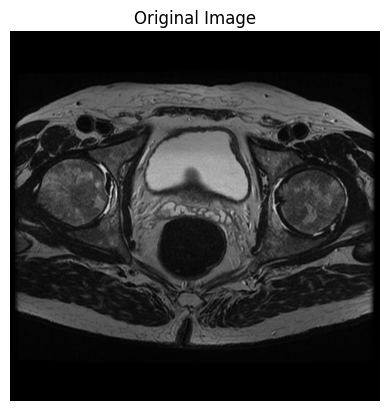

Génération 1 - Meilleur score : 0.012558099123094846
Génération 2 - Meilleur score : 0.019921865055741006
Génération 3 - Meilleur score : 0.019921865055741006
Génération 4 - Meilleur score : 0.023630733613533596
Génération 5 - Meilleur score : 0.023630733613533596
Génération 6 - Meilleur score : 0.023630733613533596
Génération 7 - Meilleur score : 0.023630733613533596
Génération 8 - Meilleur score : 0.023630733613533596
Génération 9 - Meilleur score : 0.023630733613533596
Génération 10 - Meilleur score : 0.033703182466326934
Noyau généré :
[[  3.   0.   0.  -5.   5.   0.   2.]
 [ -3.   4.   2.  -4.  -1.  -9.  -7.]
 [  5.   0.   0.   1.   1.  -2.   0.]
 [  1.   4.  -1.  -4. -10.  -1.  -1.]
 [  2.   2.   3.  -2.   0.   0.   3.]
 [  4.  -2.  -1.   3.   2.  -3.   2.]
 [  0.   0.   2.   1.   3.   0.   2.]]
Image enregistrée : best_generation_10.png


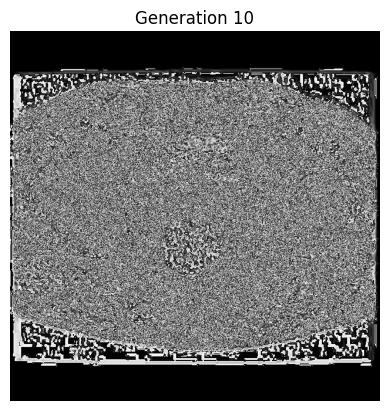

Génération 11 - Meilleur score : 0.033703182466326934
Génération 12 - Meilleur score : 0.033703182466326934
Génération 13 - Meilleur score : 0.033703182466326934
Génération 14 - Meilleur score : 0.03549287615374582
Génération 15 - Meilleur score : 0.03549287615374582
Génération 16 - Meilleur score : 0.03625302880911832
Génération 17 - Meilleur score : 0.03625302880911832
Génération 18 - Meilleur score : 0.040695251617446124
Génération 19 - Meilleur score : 0.040695251617446124
Génération 20 - Meilleur score : 0.040695251617446124
Noyau généré :
[[  3.   1.  -3.   0.   3.  -1.   1.]
 [  0.   4.   2.  -2.   0.  -4.  -5.]
 [  3.  -1.  -1.  -1.   1.   0.  -2.]
 [  2.   4.   1.  -4. -10.  -1.  -1.]
 [  0.   1.   3.  -2.   1.   0.   2.]
 [  2.  -5.   1.   1.   2.  -1.   1.]
 [  0.   2.   2.   2.   0.   0.   0.]]
Image enregistrée : best_generation_20.png


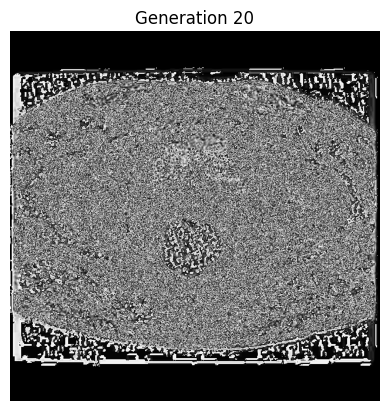

Génération 21 - Meilleur score : 0.040695251617446124
Génération 22 - Meilleur score : 0.040695251617446124
Génération 23 - Meilleur score : 0.040695251617446124
Génération 24 - Meilleur score : 0.040695251617446124
Génération 25 - Meilleur score : 0.040695251617446124
Génération 26 - Meilleur score : 0.040695251617446124
Génération 27 - Meilleur score : 0.040695251617446124
Génération 28 - Meilleur score : 0.04386371606504294
Génération 29 - Meilleur score : 0.04386371606504294
Génération 30 - Meilleur score : 0.04386371606504294
Noyau généré :
[[  3.   1.  -3.   0.   3.  -1.   2.]
 [  0.   4.   1.  -2.   0.  -5.  -5.]
 [  3.  -2.   0.   0.   1.   0.  -1.]
 [  2.   5.   1.  -3. -10.  -2.  -1.]
 [  1.   1.   4.  -2.   1.   0.   1.]
 [  0.  -4.   1.   2.   2.  -1.   2.]
 [  1.   0.   1.   0.   0.   0.   0.]]
Image enregistrée : best_generation_30.png


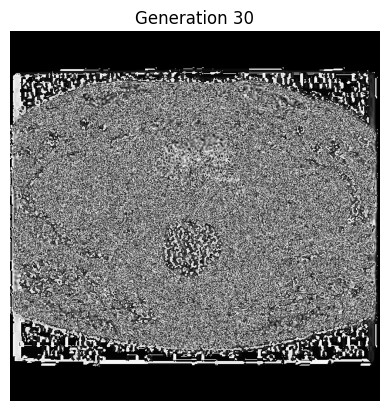

Génération 31 - Meilleur score : 0.046624834002738466
Génération 32 - Meilleur score : 0.046624834002738466
Génération 33 - Meilleur score : 0.046624834002738466
Génération 34 - Meilleur score : 0.046624834002738466


KeyboardInterrupt: 

In [26]:
# Initialiser le placeholder avec l'image originale
display_image(bitmap_to_mat(original_image), "Original Image")

ga_instance.run()

best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution()
best_chromosome = EdgeChromosome(20)
best_chromosome.genes = [np.array(best_solution[i:i+49]).reshape(7, 7).astype(np.int64) for i in range(0, len(best_solution), 49)]
fitness.display_chromosome_result(best_chromosome, "best", ga_instance.generations_completed)
print(f"Meilleure solution trouvée avec un score de {best_solution_fitness}.")